# Modeling the Tissue-curve for the PET-Center Turku

### First we need to import libraries for the analysis:

Numpy is a numerical library that provides mathematical tools for python. Matplotlib is used for plotting and pandas is used for dataframe manipulation. Scipy is a library that provides algorithms for optimization, integration, interpolation, eigenvalue problems, algebraic equations, differential equations, statistics and many other classes of problems. From scipy we only need functions for optimization and interpolation.

We also have created a python module called functions where we define more functions. We explain aforementioned functions as we use them but you can also view the source code in the same source as this notebook.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.interpolate import interp1d
import scipy.optimize as optimize
from functions import *

### Importing data

The data is provided in one Excel-file that has multiple sheets. We need to iterate through all of the sheets and save the data from each one of the sheets to the pandas dataframe for easier access. In the loop we iterate through all of the sheets, add them to a list of dataframes and in the end combine all six of the dataframes into one main dataframe.

We are also defining a new variable in the dataframe called midpoint. Midpoint is a real value that is defined as the midwaypoint between the time_start and the time_end timestamps.

In [2]:
data = pd.read_excel("/home/mikael/Documents/SMAT_projekti/TACs.xlsx", sheet_name=None)
relevant_keys = ['PT 300 ml Qclear 2', 'PT 300 ml Qclear 1', 'PT 200 ml Qclear 2', 'PT 200 ml Qclear 1', 'PT 100 ml Qclear 2', 'PT 100 ml Qclear 1']
samples = [2, 1, 2, 1, 2, 1]
flows = [300, 300, 200, 200, 100, 100]
frames = []

for key, sample, flow in zip(relevant_keys, samples, flows):
    frame = data[key]
    df = frame.loc[5:]
    df.columns = ["time", "input", "tissue"]
    df[['time_start', 'time_end']] = df['time'].str.split(' - ', 1, expand=True)
    df = df.assign(sample=sample, flow=flow)
    df = df.astype({'input': 'float64', 'tissue': 'float64', 'time_start': 'int32', 'time_end': 'int32'})
    df = df.drop(["time"], axis=1)
    df["midpoint"] = (df["time_end"] + df["time_start"]) / 2
    frames.append(df)
df = pd.concat(frames)
df

/home/mikael/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


,input,tissue,time_start,time_end,sample,flow,midpoint
5,1.456478e+03,407.96191,0,5,2,300,2.5
6,1.278932e+03,459.05683,5,10,2,300,7.5
7,2.265328e+04,646.44457,10,15,2,300,12.5
8,4.574733e+05,10505.08901,15,20,2,300,17.5
9,1.643083e+06,89934.22971,20,25,2,300,22.5
...,...,...,...,...,...,...,...
24,1.392625e+06,784895.39999,140,160,1,100,150.0
25,6.902623e+05,925024.12368,160,190,1,100,175.0
26,2.563172e+05,870937.93689,190,220,1,100,205.0
27,7.789175e+04,634442.87209,220,250,1,100,235.0


### Creating more features

In our model we are going to need more features than we have in the dataset. We are needing the timepoint where the input curve reaches it's maximum value. We also need to calculate the integral for the tissue curve as we are going to normalize it so the optimization problem becomes easier later on.

We group the dataframe by different flow and sample values and calculate aforementioned values for each of the subdataframes. In the end we create a pandas dataframe from our dictionary and merge it with our original dataframe.

In [3]:
feature_df = {
    "flow": [],
    "sample": [],
    "tissue_integral": [],
    "input_x_max": [],
    "tissue_x_max": []
}

for name, group in df.groupby(['sample', 'flow']):
    feature_df["flow"].append(group["flow"].iloc[0])
    feature_df["sample"].append(group["sample"].iloc[0])

    # Creating interpolation out of both functions
    cubic_input = interp1d(group["midpoint"], group["input"], kind='cubic')
    cubic_tissue = interp1d(group["midpoint"], group["tissue"], kind='cubic')
    min_inter, max_inter = min(group["midpoint"]), max(group["midpoint"])

    # Finding in which timepoint the input function reaches maximum flow value
    results = optimize.minimize(lambda x: -cubic_input(x), x0=(100), bounds = [(min_inter + 1, max_inter - 1)])
    feature_df["input_x_max"].append(results["x"][0])

    # Finding in which timepoint the tissue function reaches maximum flow value
    results = optimize.minimize(lambda x: -cubic_tissue(x), x0=(100), bounds = [(min_inter + 1, max_inter - 1)])
    feature_df["tissue_x_max"].append(results["x"][0])

    # Finding the integral of the tissue function
    integral = np.trapz(group["tissue"], x=group["midpoint"])
    feature_df["tissue_integral"].append(integral)

feature_df = pd.DataFrame(feature_df)
df = pd.merge(df, feature_df, how="left", on=["flow", "sample"])
df

,input,tissue,time_start,time_end,sample,flow,midpoint,tissue_integral,input_x_max,tissue_x_max
0,1.456478e+03,407.96191,0,5,2,300,2.5,4.000549e+07,28.483992,47.474071
1,1.278932e+03,459.05683,5,10,2,300,7.5,4.000549e+07,28.483992,47.474071
2,2.265328e+04,646.44457,10,15,2,300,12.5,4.000549e+07,28.483992,47.474071
3,4.574733e+05,10505.08901,15,20,2,300,17.5,4.000549e+07,28.483992,47.474071
4,1.643083e+06,89934.22971,20,25,2,300,22.5,4.000549e+07,28.483992,47.474071
...,...,...,...,...,...,...,...,...,...,...
139,1.392625e+06,784895.39999,140,160,1,100,150.0,1.091706e+08,118.793711,182.669720
140,6.902623e+05,925024.12368,160,190,1,100,175.0,1.091706e+08,118.793711,182.669720
141,2.563172e+05,870937.93689,190,220,1,100,205.0,1.091706e+08,118.793711,182.669720
142,7.789175e+04,634442.87209,220,250,1,100,235.0,1.091706e+08,118.793711,182.669720


Now we are creating a new variable called scaled_tissue. Scaled_tissue is the value of the tissue function divided (scaled) by it's total integral.

In [4]:
df["scaled_tissue"] = df["tissue"] / df["tissue_integral"]

### Sampling from original dataset:

In the original dataset we had issues when the readings where done in infrequent times. At the beginning the readings were taken every 5 seconds but later on the frequency was lowered to 20 seconds. We are going to fix this by sampling set amount of points in even intervals from the original curve. We are doing this by using get_interpolated_sample function that takes data that is grouped by flow and sample, then the function fits a cubic split interpolation into the data. Finally we sample set amount of points (currently 500) in even intervals from the interpolation. Variable x in the dataframe is the timepoint where we calculate the y-value from the interpolation.

In [5]:
sampled_dict = {
    "x": [],
    "ss_tissue": [],
    "s_tissue": [],
    "sample": [],
    "flow": []
}

num_samples = 500
for name, group in df.groupby(['sample', 'flow']):
    results = get_interpolated_sample(
        min(df["midpoint"]),
        max(df["midpoint"]),
        group, 
        num_samples, 
        ["scaled_tissue", "tissue"], 
        "midpoint"
    )
    sampled_dict["x"].append(results[0])
    sampled_dict["ss_tissue"].append(results[1][0])
    sampled_dict["s_tissue"].append(results[1][1])
    sampled_dict["sample"].append(np.repeat(group["sample"].iloc[0], num_samples))
    sampled_dict["flow"].append(np.repeat(group["flow"].iloc[0], num_samples))

open_list = lambda x: [item for sublist in x for item in sublist]

for key in sampled_dict.keys():
    sampled_dict[key] = open_list(sampled_dict[key])

sampled_df = pd.DataFrame(sampled_dict)
sampled_df = pd.merge(sampled_df, feature_df, how="inner", on=["sample", "flow"])
sampled_df


,x,ss_tissue,s_tissue,sample,flow,tissue_integral,input_x_max,tissue_x_max
0,2.500000,0.000012,1267.153700,1,100,1.091706e+08,118.793711,182.669720
1,3.026052,0.000012,1272.243678,1,100,1.091706e+08,118.793711,182.669720
2,3.552104,0.000012,1277.155441,1,100,1.091706e+08,118.793711,182.669720
3,4.078156,0.000012,1281.909044,1,100,1.091706e+08,118.793711,182.669720
4,4.604208,0.000012,1286.524541,1,100,1.091706e+08,118.793711,182.669720
...,...,...,...,...,...,...,...,...
2995,262.895792,0.000034,1360.482562,2,300,4.000549e+07,28.483992,47.474071
2996,263.421844,0.000034,1357.702401,2,300,4.000549e+07,28.483992,47.474071
2997,263.947896,0.000034,1354.824264,2,300,4.000549e+07,28.483992,47.474071
2998,264.473948,0.000034,1351.845891,2,300,4.000549e+07,28.483992,47.474071


In [6]:
sampled_df["error_weigth"] = np.where(((sampled_df["x"] < sampled_df["tissue_x_max"]) & (sampled_df["flow"] == 100) & (sampled_df["sample"] == 1)), 1,  2000)
sampled_df["error_weight"] = 1

STARTING FIRST OPTIMIZE
ENDING FIRST OPTIMIZE. PARAMS: [4.61142333e+00 4.88283098e+01 3.63182091e-02 9.55032764e-03]
STARTING SECOND OPTIMIZE
ENDING SECOND OPTIMIZE. PARAMS: [1042649.41717557]
FLOW: 100, SAMPLE: 1, SIGMA: 48.82830981650109, LAMBDA: 0.03631820909729589, MU: 164.90794472510194, MU_x: 4.611423328105529


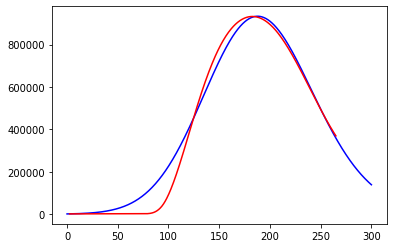

STARTING FIRST OPTIMIZE
ENDING FIRST OPTIMIZE. PARAMS: [6.32073792e+00 4.79865515e+01 1.05431027e-01 8.21328262e-03]
STARTING SECOND OPTIMIZE
ENDING SECOND OPTIMIZE. PARAMS: [729392.78539638]
FLOW: 100, SAMPLE: 2, SIGMA: 47.98655151829487, LAMBDA: 0.10543102747493319, MU: 121.79411130692475, MU_x: 6.320737924198539


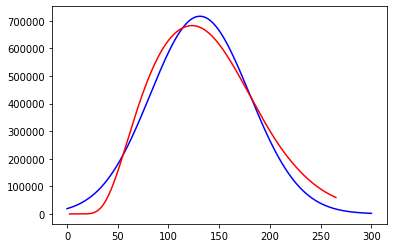

STARTING FIRST OPTIMIZE
ENDING FIRST OPTIMIZE. PARAMS: [3.63786126e+00 2.12256065e+01 3.94521773e-02 1.91478451e-02]
STARTING SECOND OPTIMIZE
ENDING SECOND OPTIMIZE. PARAMS: [1152855.04523479]
FLOW: 200, SAMPLE: 1, SIGMA: 21.225606499018934, LAMBDA: 0.03945217732010889, MU: 65.50540710816534, MU_x: 3.63786126125207


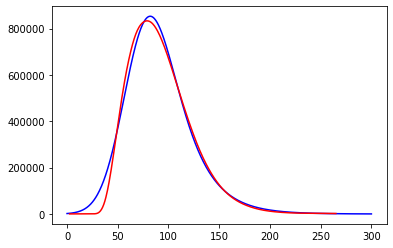

STARTING FIRST OPTIMIZE
ENDING FIRST OPTIMIZE. PARAMS: [3.49104328e+00 2.11311321e+01 3.99568375e-02 1.92175134e-02]
STARTING SECOND OPTIMIZE
ENDING SECOND OPTIMIZE. PARAMS: [1189326.28211257]
FLOW: 200, SAMPLE: 2, SIGMA: 21.13113206144381, LAMBDA: 0.03995683753077499, MU: 65.67015324625483, MU_x: 3.491043284112492


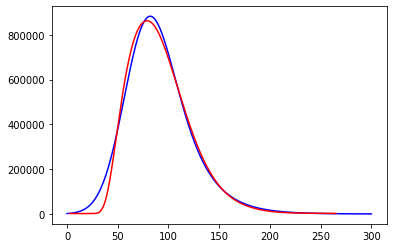

STARTING FIRST OPTIMIZE
ENDING FIRST OPTIMIZE. PARAMS: [ 2.4403604  11.19510022  0.04237529  0.03647235]
STARTING SECOND OPTIMIZE
ENDING SECOND OPTIMIZE. PARAMS: [1419260.06474926]
FLOW: 300, SAMPLE: 1, SIGMA: 11.195100217307608, LAMBDA: 0.042375289853517295, MU: 36.71848459694735, MU_x: 2.4403603952906003


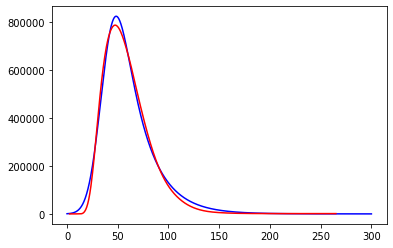

STARTING FIRST OPTIMIZE
ENDING FIRST OPTIMIZE. PARAMS: [ 6.36072181 18.95464537  0.25583491  0.02026827]
STARTING SECOND OPTIMIZE
ENDING SECOND OPTIMIZE. PARAMS: [810778.60786991]
FLOW: 300, SAMPLE: 2, SIGMA: 18.95464537461887, LAMBDA: 0.2558349134024604, MU: 49.68639765385058, MU_x: 6.360721810206645


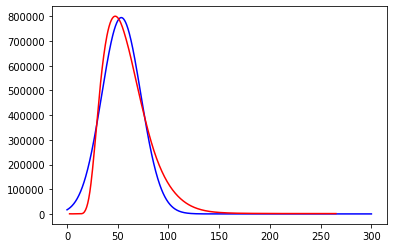

,flow,sample,mu,mu_x,lambda_,sigma,h,tissue_integral,input_x_max,tissue_x_max
0,100,1,164.907945,4.611423,0.036318,48.828310,1.042649e+06,1.091706e+08,118.793711,182.669720
1,100,2,121.794111,6.320738,0.105431,47.986552,7.293928e+05,8.881070e+07,58.586732,123.186942
2,200,1,65.505407,3.637861,0.039452,21.225606,1.152855e+06,6.020789e+07,47.316101,78.880157
3,200,2,65.670153,3.491043,0.039957,21.131132,1.189326e+06,6.188868e+07,48.214937,78.895128
4,300,1,36.718485,2.440360,0.042375,11.195100,1.419260e+06,3.891364e+07,28.583950,47.416007
5,300,2,49.686398,6.360722,0.255835,18.954645,8.107786e+05,4.000549e+07,28.483992,47.474071


In [7]:
groups = sampled_df.groupby(["flow", "sample"]) # NON PARAMETRIC

results_dict = {
    "flow": [],
    "sample": [],
    "mu": [],
    "mu_x": [],
    "lambda_": [],
    "sigma": [],
    "h": []
}

alkuarvaukset = [
        [6.325, 20, 0.05], # Muiden alkuarvaus
        [6.325, 48, 0.022], # 300, 2
        [4.6, 48.84, 0.027] # 300, 1
    ]
for i, group in groups:
    if i[0] == 100:
        if i[1] == 1:
            alkuarvaus = alkuarvaukset[2]
        else:
            alkuarvaus = alkuarvaukset[1]
    else:
        alkuarvaus = alkuarvaukset[0]
    mu_x_alkuarvaus, sigma_alkuarvaus, lambda_alkuarvaus = alkuarvaus

    bounds = [(None, None), (1e-5, None), (1e-5, None), (None, None)]

    x_0 = [mu_x_alkuarvaus, sigma_alkuarvaus, lambda_alkuarvaus, 1]
    print("STARTING FIRST OPTIMIZE")
    # SOVITTAA NORMALISOITUUN KÄYRÄÄN PARAMETRIT
    res1 = scipy.optimize.minimize(EMG_loss, args=group, x0=x_0, bounds=bounds)
    print(f"ENDING FIRST OPTIMIZE. PARAMS: {res1['x']}")
    #res = scipy.optimize.differential_evolution(EMG_loss, bounds=bounds, args=[group])
    x_range = np.linspace(0, 300, 900)
    mu = (group["input_x_max"] + res1["x"][0] * 1000 / group["flow"]).iloc[0]
    sigma = res1["x"][1]
    lambda_ = res1["x"][2]

    emg_params = {
        "mu_x": res1["x"][0],
        "sigma": sigma,
        "lambda_": lambda_
    }

    print("STARTING SECOND OPTIMIZE")
    # SOVITTAA KORKEUSPARAMETRIN NIIN ETTÄ SE NORMALISOIMATON MÄTSÄÄ OIKEAAN
    res2 = scipy.optimize.minimize(EMG_loss_h, args=(group, emg_params), x0=[80000])
    print(f"ENDING SECOND OPTIMIZE. PARAMS: {res2['x']}")

    h = res2["x"][0]


    pred_y = EMG(x_range, mu, sigma, lambda_, h)
    plt.plot(x_range, pred_y, color="b")
    plt.plot(group["x"], group["s_tissue"], color="r")
    print(f'FLOW: {group["flow"].iloc[0]}, SAMPLE: {group["sample"].iloc[0]}, SIGMA: {sigma}, LAMBDA: {lambda_}, MU: {mu}, MU_x: {res1["x"][0]}')
    plt.show()
    results_dict["flow"].append(group["flow"].iloc[0])
    results_dict["sample"].append(group["sample"].iloc[0])
    results_dict["mu"].append(mu)
    results_dict["mu_x"].append(res1["x"][0])
    results_dict["sigma"].append(sigma)
    results_dict["lambda_"].append(lambda_)
    results_dict["h"].append(h)

results_df = pd.DataFrame(results_dict)
results_df = results_df.merge(feature_df, how="inner", on=["flow", "sample"])
results_df

In [8]:
param_dict = {
    "mu_x_count": 1,
    "sigma_count": 2,
    "lambda_count": 1,
    "h_count": 1
}

{'mu_x': 5.009794428896013, 'sigma': 48.40743066739799, 'lambda_': 0.04744616744224465, 'h': 942877.9162446093}


TypeError: set_text() takes 2 positional arguments but 3 were given

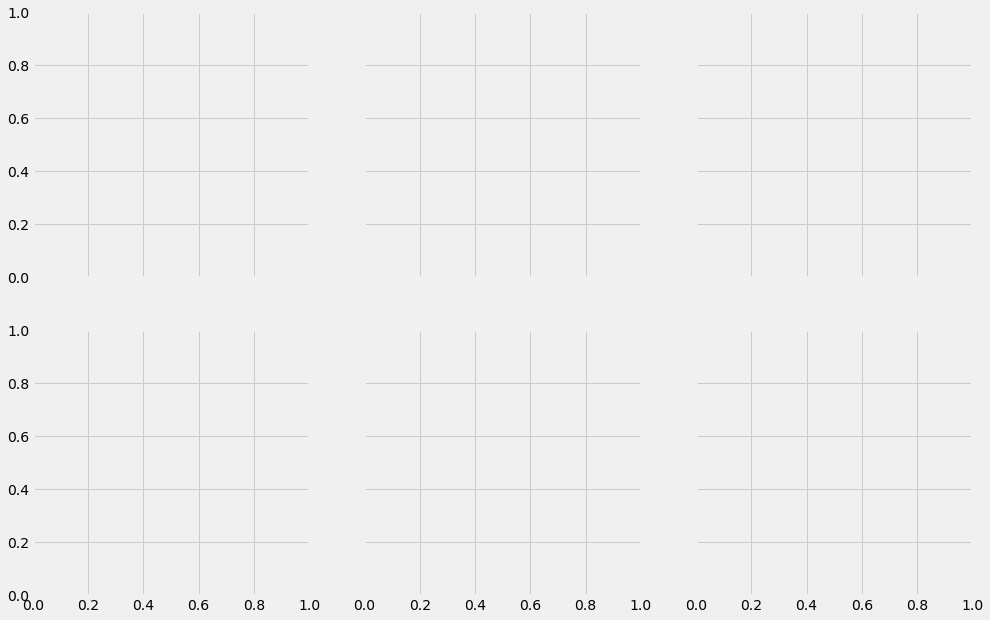

In [12]:
def plot_against_predictions_all(results_df, df, param_dict, save=False):
    x_range = np.linspace(0, 350, 700)
    plt.style.use('fivethirtyeight')
    fig, ax = plt.subplots(2, 3, figsize=(15, 10), sharex=True, sharey=True, num="bmh")
    for i, group in df.groupby(["flow", "sample"]):
        flow, sample = i
        row, column = sample - 1, int(flow / 100 - 1)
        model_param_dict = get_model_params(flow=flow, results_df = results_df, parameter_dict=param_dict)
        r2 = get_r2(group, [model_param_dict["mu_x"], model_param_dict["sigma"], model_param_dict["lambda_"], model_param_dict["h"]])
        r2 = str(round(r2, 2))
        mu = (group["input_x_max"] + model_param_dict["mu_x"] * 1000 / flow).iloc[0]
        emg_vals = EMG(x_range, mu, model_param_dict["sigma"], model_param_dict["lambda_"], model_param_dict["h"])
        ax[row, column].title.set_text(f"Flow: {flow}, Sample: {sample}, R2: {r2}", 4)
        ax[row, column].scatter(group["midpoint"], group["tissue"], color="r")
        ax[row, column].plot(x_range, emg_vals, color="b")
    if save:
        fig.savefig("all_predictions.jpg")
    plt.style.use("default")

param_dict = {
    "mu_x_count": 1,
    "sigma_count": 2,
    "lambda_count": 1,
    "h_count": 1
}
plot_against_predictions_all(results_df, df, param_dict)

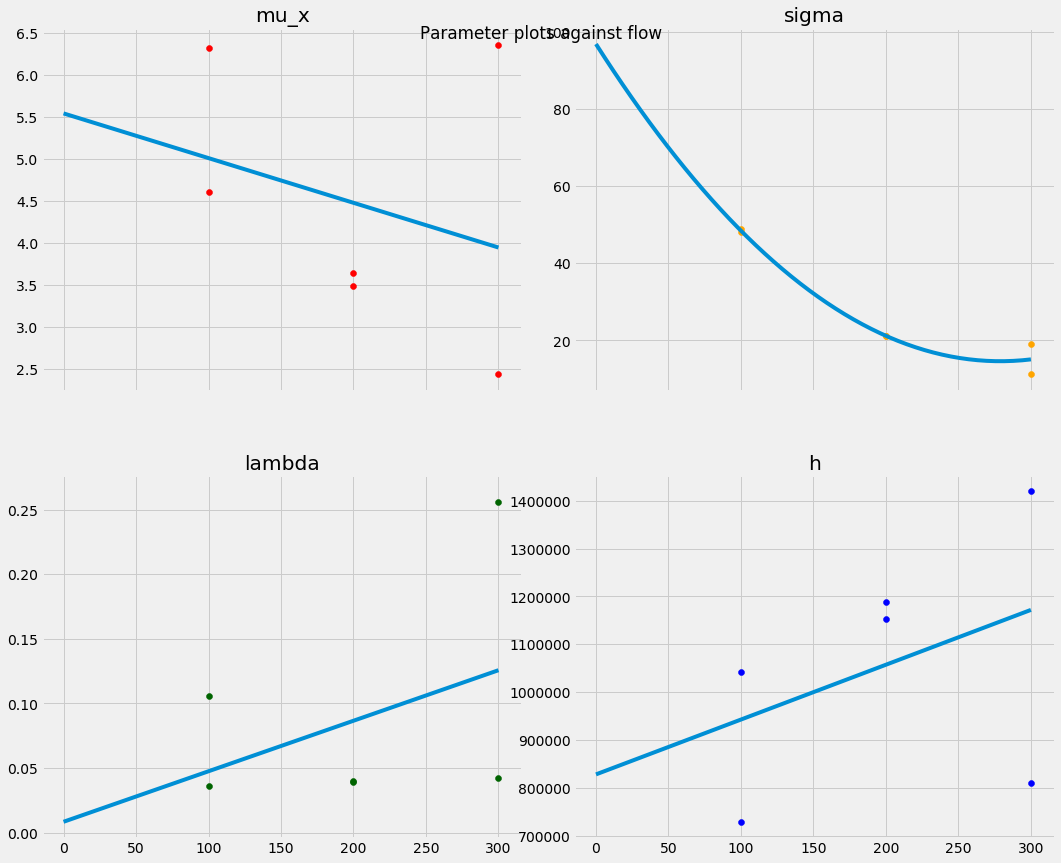

In [ ]:
parameter_dict = {
    "sigma_count": 2,
    "lambda_count": 1,
    "mu_x_count": 1,
    "h_count": 1
}
plot_all_params(results_df, param_dict)

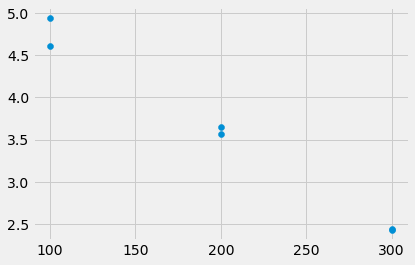

In [ ]:
plt.scatter(results_df["flow"], results_df["mu_x"])

<AxesSubplot:xlabel='flow', ylabel='sigma'>

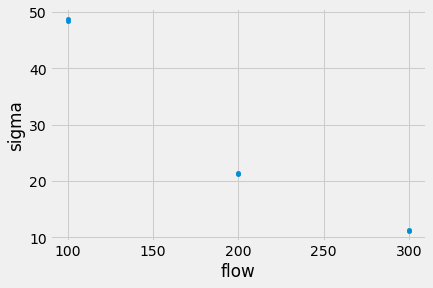

In [ ]:
results_df.plot.scatter("flow", "sigma")

<AxesSubplot:xlabel='flow', ylabel='lambda_'>

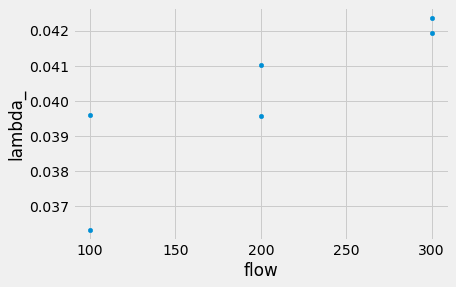

In [ ]:
results_df.plot.scatter("flow", "lambda_")

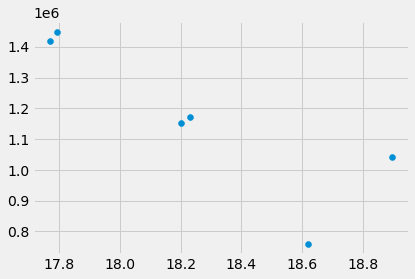

In [ ]:
plt.scatter(np.log(results_df["input_integral"]), results_df["h"])

NameError: name 'fit_polynomial' is not defined

NameError: name 'fit_2d_poly' is not defined

y = exp(x * lambda_ + mu)

mu_x = 500 - 100 * flow

lambda = 0.038 + 0.02 * flow

mu = (input_x_max + mu_x * 100) / flow

In [ ]:
selected = get_selected_df(results_df, 300, 2)
print(selected)

   flow  sample         mu      mu_x   lambda_      sigma             h  \
5   300       2  36.609103  2.437533  0.041927  11.267589  1.449293e+06   

      tissue_max  tissue_x_max  input_integral  tissue_integral     input_max  \
5  800428.816009     47.474071    5.337498e+07     4.000549e+07  2.401110e+06   

   input_x_max            std  skewness           mean  peak_time_difference  
5    28.483992  305452.965103  0.540881  282056.386815             18.990079  


(2.4389628846735034,
 11.231242908323306,
 0.042150857517905024,
 1417588.178784034)

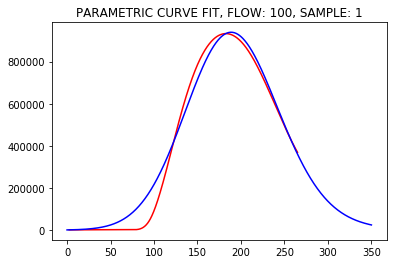

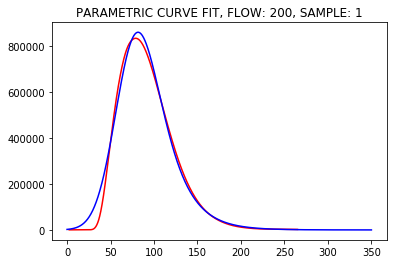

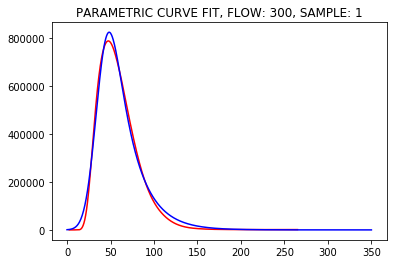

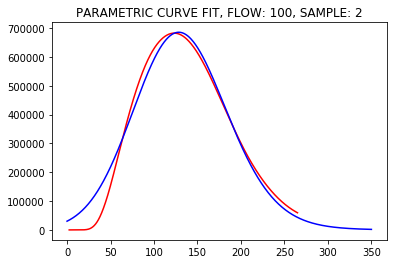

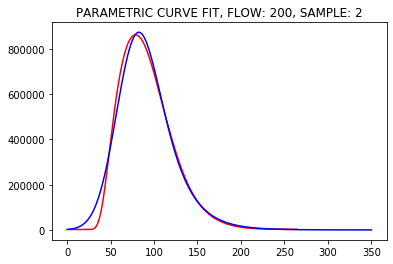

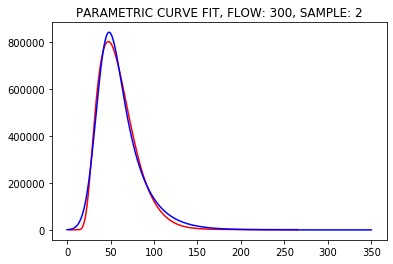

In [ ]:
sampled_df

,ss_tissue,s_tissue,x,flow,sample,tissue_max,tissue_x_max,input_integral,tissue_integral,input_max,input_x_max,std,skewness,mean,peak_time_difference
0,0.000012,1267.153700,2.500000,100,1,932660.007290,182.669720,1.608301e+08,1.091706e+08,2.305769e+06,118.793711,309106.389210,1.395397,184164.407288,63.876009
1,0.000012,1267.412249,2.526253,100,1,932660.007290,182.669720,1.608301e+08,1.091706e+08,2.305769e+06,118.793711,309106.389210,1.395397,184164.407288,63.876009
2,0.000012,1267.670307,2.552505,100,1,932660.007290,182.669720,1.608301e+08,1.091706e+08,2.305769e+06,118.793711,309106.389210,1.395397,184164.407288,63.876009
3,0.000012,1267.927877,2.578758,100,1,932660.007290,182.669720,1.608301e+08,1.091706e+08,2.305769e+06,118.793711,309106.389210,1.395397,184164.407288,63.876009
4,0.000012,1268.184960,2.605011,100,1,932660.007290,182.669720,1.608301e+08,1.091706e+08,2.305769e+06,118.793711,309106.389210,1.395397,184164.407288,63.876009
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,0.000034,1349.388320,264.894989,300,2,800428.816009,47.474071,5.337498e+07,4.000549e+07,2.401110e+06,28.483992,305452.965103,0.540881,282056.386815,18.990079
59996,0.000034,1349.232885,264.921242,300,2,800428.816009,47.474071,5.337498e+07,4.000549e+07,2.401110e+06,28.483992,305452.965103,0.540881,282056.386815,18.990079
59997,0.000034,1349.077191,264.947495,300,2,800428.816009,47.474071,5.337498e+07,4.000549e+07,2.401110e+06,28.483992,305452.965103,0.540881,282056.386815,18.990079
59998,0.000034,1348.921236,264.973747,300,2,800428.816009,47.474071,5.337498e+07,4.000549e+07,2.401110e+06,28.483992,305452.965103,0.540881,282056.386815,18.990079


In [ ]:
results_df["input_integral"]

0    1.608301e+08
1    1.219042e+08
2    8.032373e+07
3    8.260553e+07
4    5.215457e+07
5    5.337498e+07
Name: input_integral, dtype: float64

In [ ]:
results_df

,flow,sample,mu,mu_x,lambda_,sigma,h,tissue_max,tissue_x_max,input_integral,tissue_integral,input_max,input_x_max,std,skewness,mean,peak_time_difference
0,100,1,133.249437,1.445573,0.007161,20.784495,3.459232e+06,932660.007290,182.669720,1.608301e+08,1.091706e+08,2.305769e+06,118.793711,309106.389210,1.395397,184164.407288,63.876009
1,100,2,78.511753,1.992502,0.011079,20.598585,1.967882e+06,682379.493759,123.186942,1.219042e+08,8.881070e+07,1.772555e+06,58.586732,237359.182831,0.571097,242688.100938,64.600210
2,200,1,62.781911,3.093162,0.032624,18.163393,1.354485e+06,833308.431967,78.880157,8.032373e+07,6.020789e+07,2.323809e+06,47.316101,310345.925135,0.689358,268301.277536,31.564057
3,200,2,66.065430,3.570099,0.041064,21.464332,1.169426e+06,862367.856082,78.895128,8.260553e+07,6.188868e+07,2.476852e+06,48.214937,320526.422085,0.701743,276009.680701,30.680192
4,300,1,36.718591,2.440392,0.042375,11.194897,1.419294e+06,786471.515392,47.416007,5.215457e+07,3.891364e+07,2.355921e+06,28.583950,299429.502224,0.552632,275034.624421,18.832057
5,300,2,36.609103,2.437533,0.041927,11.267589,1.449293e+06,800428.816009,47.474071,5.337498e+07,4.000549e+07,2.401110e+06,28.483992,305452.965103,0.540881,282056.386815,18.990079


                            OLS Regression Results                            
Dep. Variable:                      h   R-squared:                       0.977
Model:                            OLS   Adj. R-squared:                  0.962
Method:                 Least Squares   F-statistic:                     64.61
Date:                Wed, 03 Nov 2021   Prob (F-statistic):            0.00342
Time:                        14:14:57   Log-Likelihood:                -78.554
No. Observations:                   6   AIC:                             163.1
Df Residuals:                       3   BIC:                             162.5
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept      -4.519e+06   9.27e+05     -4.

/home/mikael/anaconda3/lib/python3.7/site-packages/statsmodels/stats/stattools.py:71: ValueWarning: omni_normtest is not valid with less than 8 observations; 6 samples were given.
  "samples were given." % int(n), ValueWarning)


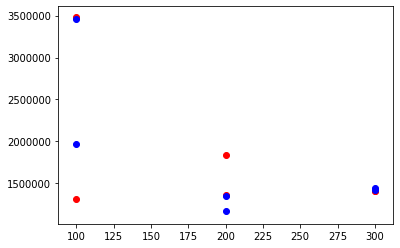

In [ ]:
fit = smf.ols('h ~ input_integral + flow', data=results_df).fit()
print(fit.summary())
y_pred = fit.predict(feature_df)
plt.scatter(results_df["flow"], y_pred, color="r")
plt.scatter(results_df["flow"], results_df["h"], color="b")

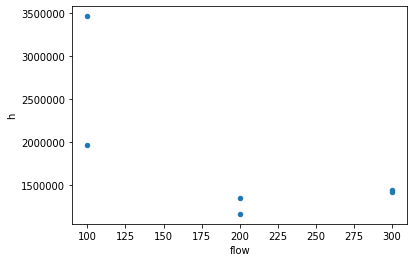

In [ ]:
results_df.plot.scatter("flow", "h")

In [ ]:

def plot_against_predictions(flow, sample, results_df, df):
    #CREATE X-RANGE, GET MODEL PARAMETERS
    x_range = np.linspace(0, 350, 700)
    mu_x, sigma, lambda_ = get_model_params(flow, results_df)
    data = get_selected_df(df, flow, sample)
    # TRANSFORM MU_X -> MU
    mu = (data["input_x_max"] + mu_x * 1000 / data["flow"]).iloc[0]
    #CREATE Y-VALUES
    h = get_selected_df(results_df, flow, sample)["h"].iloc[0]
    emg_vals = EMG(x_range, mu, sigma, lambda_, h)

    plt.plot(data["x"], data["s_tissue"], color="r")
    plt.plot(x_range, emg_vals, color="b")

In [ ]:
plot_against_predictions(300, 1, results_df, sampled_df)

TypeError: get_model_params() missing 1 required positional argument: 'results_df'

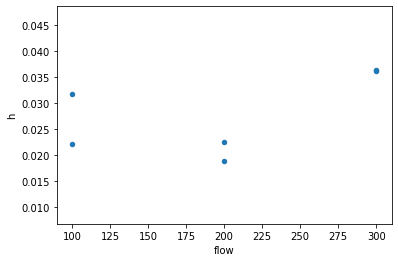

In [ ]:
results_df.plot.scatter("flow", "h")

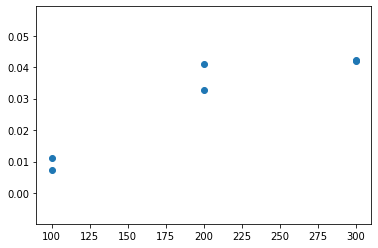

In [ ]:
plt.scatter(results_df["flow"], results_df["lambda_"])

In [ ]:
results_df

,flow,sample,mu,mu_x,lambda_,sigma,h,tissue_max,tissue_x_max,input_integral,tissue_integral,input_max,input_x_max,std,skewness,mean,peak_time_difference,predicted_values
0,100,1,133.249437,1.445573,0.007161,20.784495,0.031685,932660.007290,182.669720,1.608301e+08,1.091706e+08,2.305769e+06,118.793711,309106.389210,1.395397,184164.407288,63.876009,17.930943
1,100,2,78.511753,1.992502,0.011079,20.598585,0.022158,682379.493759,123.186942,1.219042e+08,8.881070e+07,1.772555e+06,58.586732,237359.182831,0.571097,242688.100938,64.600210,17.667981
2,200,1,62.781911,3.093162,0.032624,18.163393,0.022497,833308.431967,78.880157,8.032373e+07,6.020789e+07,2.323809e+06,47.316101,310345.925135,0.689358,268301.277536,31.564057,17.272113
3,200,2,66.065430,3.570099,0.041064,21.464332,0.018896,862367.856082,78.895128,8.260553e+07,6.188868e+07,2.476852e+06,48.214937,320526.422085,0.701743,276009.680701,30.680192,17.298694
4,300,1,36.718591,2.440392,0.042375,11.194897,0.036472,786471.515392,47.416007,5.215457e+07,3.891364e+07,2.355921e+06,28.583950,299429.502224,0.552632,275034.624421,18.832057,16.862313
5,300,2,36.609103,2.437533,0.041927,11.267589,0.036227,800428.816009,47.474071,5.337498e+07,4.000549e+07,2.401110e+06,28.483992,305452.965103,0.540881,282056.386815,18.990079,16.884262


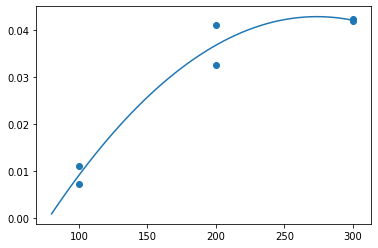

In [ ]:
coefficients = np.polyfit(results_df["flow"], results_df["lambda_"], 2)
func = np.poly1d(coefficients)
x_range = np.linspace(80, 300)
y_s = func(x_range)
plt.plot(x_range, y_s)
plt.scatter(results_df["flow"], results_df["lambda_"])

In [ ]:
aa = results_df.groupby(["flow"]).mean()
aa.reset_index(level=0, inplace=True)

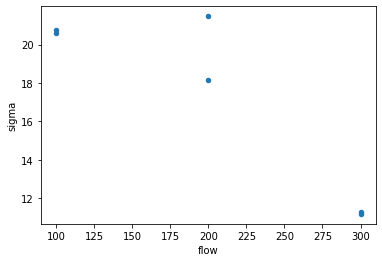

In [ ]:
results_df.plot.scatter("flow", "sigma")

FLOW: 100, SAMPLE: 1, SIGMA: 3218.569319725927, LAMBDA: 8.630069276865442e-07, MU_x: 6.283315221181237


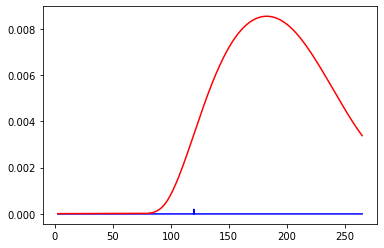

FLOW: 100, SAMPLE: 2, SIGMA: 3218.566713739128, LAMBDA: 8.437611749139164e-07, MU_x: 6.292302956573166


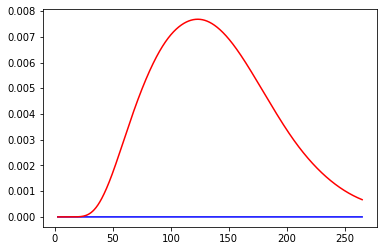

KeyboardInterrupt: 

In [ ]:
groups = sampled_df.groupby(["flow", "sample"]) #PARAMETRIC
results_dict = {
    "flow": [],
    "sample": [],
    "mu": [],
    "mu_x": [],
    "lambda_": [],
    "sigma": []
}
for i, group in groups:
    mu_x_alkuarvaus = 6.3259260
    sigma_alkuarvaus = 32.18558379022995 * group["flow"].iloc[0]
    lambda_alkuarvaus = 0.01275965604990928 / group["flow"].iloc[0]
    bounds = [(mu_x_alkuarvaus - 4, mu_x_alkuarvaus + 4),
         (4, 300),
         (0.01, 20), (0, 3)]

    x_0 = [mu_x_alkuarvaus, sigma_alkuarvaus, lambda_alkuarvaus, 1]

    res = scipy.optimize.minimize(EMG_loss, args=group, x0=x_0)
    #res = scipy.optimize.differential_evolution(EMG_loss, bounds=bounds, args=[group])
    x_range = np.linspace(0, 300, 900)
    mu = (group["input_x_max"] + params[0] * 1000 / group["flow"]).iloc[0]
    sigma = (params[1] / group["flow"]).iloc[0]
    lambda_ = (np.exp(params[2] * group["flow"])).iloc[0]
    h = params[3]
    pred_y = EMG(group["x"], mu, sigma, lambda_, h)
    plt.plot(group["x"], pred_y, color="b")
    plt.plot(group["x"], group["ss_tissue"], color="r")
    print(f'FLOW: {group["flow"].iloc[0]}, SAMPLE: {group["sample"].iloc[0]}, SIGMA: {res["x"][1]}, LAMBDA: {res["x"][2]}, MU_x: {res["x"][0]}')
    plt.show()
          
    results_dict["flow"].append(group["flow"].iloc[0])
    results_dict["sample"].append(group["sample"].iloc[0])
    results_dict["mu"].append(mu)
    results_dict["mu_x"].append(res["x"][0])
    results_dict["sigma"].append(sigma)
    results_dict["lambda_"].append(lambda_)
    

In [ ]:
results_df = pd.DataFrame(results_dict)
results_df = results_df.merge(feature_df, how="inner", on=["flow", "sample"])
results_df

In [ ]:
fit = smf.ols('np.log(lambda_) ~ I(flow)', data=results_df).fit()
print(fit.summary())

In [ ]:
plt.scatter(results_df["flow"], np.log(results_df["lambda_"]), color="r")
x_range = np.linspace(1, 300, 400)

y_s = np.exp(fit.params[1] * x_range + fit.params[0])

plt.plot(x_range, np.log(y_s), color="b")

In [ ]:
results_df

In [ ]:
plt.scatter(results_df["flow"], results_df["sigma"])

In [ ]:
#fit = smf.ols('sigma ~ I(1 / flow) + lambda_ - 1', data=results_df).fit()
fit = smf.ols('sigma ~ I(1 / flow) - 1', data=results_df).fit()
print(fit.summary())

In [ ]:
plt.scatter(results_df["flow"], results_df["sigma"], color="r")
x_range = np.linspace(100, 300, 400)

y_s = fit.params[0] / x_range

plt.plot(x_range, y_s, color="b")

In [ ]:
#fit = smf.ols('sigma ~ I(1 / flow) + lambda_ - 1', data=results_df).fit()
fit = smf.ols('mu_x ~ flow - 1', data=results_df).fit()
print(fit.summary())

In [ ]:
plt.scatter(results_df["flow"], results_df["mu_x"], color="r")
x_range = np.linspace(1, 300, 400)

y_s = fit.params[0] * x_range

plt.plot(x_range, y_s, color="b")

In [ ]:
results_df

In [ ]:
#fit = smf.ols('sigma ~ I(1 / flow) + lambda_ - 1', data=results_df).fit()
fit = smf.ols('mu_x ~ flow - 1', data=results_df).fit()
print(fit.summary())

In [ ]:
def EMG_loss(params, data):
    """
    x[0] ja x[1]: lambda_ parametrit
    x[2]: sigma_parametri
    x[3]: mu_parametri
    x[4]: h
    """
    errors = []
    #print(params)
    groups = data.groupby(["flow", "sample"])
    for i, group in groups:
        mu = (group["input_x_max"] + params[3] * 1000 / group["flow"]).iloc[0]
        lambda_ = (np.exp(params[0] * group["flow"] + params[1])).iloc[0]
        sigma = (params[2] / group["flow"]).iloc[0]
        h = params[4]
        emg_vals = EMG(group["x"], mu, lambda_, sigma, h)
        #print(np.isnan(emg_vals).any())
        error = np.sum((group["ss_tissue"] - emg_vals) ** 2)
        errors.append(error)
    return sum(errors)

In [ ]:
def EMG_loss(params, data):
    """
    x[0] ja x[1]: lambda_ parametrit
    x[2]: sigma_parametri
    x[3]: mu_parametri
    x[4]: h
    """
    errors = []
    #print(params)
    groups = data.groupby(["flow", "sample"])
    for i, group in groups:
        mu = (group["input_x_max"] + params[2] * 1000 / group["flow"]).iloc[0]
        lambda_ = (np.exp(params[0] * group["flow"])).iloc[0]
        sigma = (params[1] / group["flow"]).iloc[0]
        h = params[3]
        emg_vals = EMG(group["x"], mu, lambda_, sigma, h)
        #print(np.isnan(emg_vals).any())
        error = np.sum((group["ss_tissue"] - emg_vals) ** 2)
        errors.append(error)
    return sum(errors)

In [ ]:

x_0 = -5
x_1 = 0.1
x_2 = 3535.9386
x_3 = 0.0192
x_4 = 1

bounds = [(-30, 30),
         (0, 10),
         (0, 100000),
         (0, 20),
         (0, 50)]


bounds = [(-30, 30),
         (0, 100000),
         (0, 20),
         (0, 50)]

#x0 = [x_0, x_1, x_2, x_3, x_4]
x0 = [x_0, x_2, x_3, x_4]

res = scipy.optimize.minimize(EMG_loss, bounds=bounds, args=sampled_df, x0=x0)
print(res)
res = scipy.optimize.differential_evolution(EMG_loss, bounds=bounds, args=[sampled_df[0:801]])
#x_range = np.linspace(0, 300, 900)
#mu = (group["input_x_max"] + res["x"][0] * 1000 / group["flow"]).iloc[0]
#sigma = res["x"][1]
#lambda_ = res["x"][2]
#h = res["x"][3]
#pred_y = EMG(x_range, mu, sigma, lambda_, h)
res

In [ ]:
sampled_df[0:801]

In [ ]:
groups = sampled_df.groupby(["flow", "sample"])
vp_dict = {
    "std": [],
    "mean": [],
    "skewness": []
}
for i, group in groups:
    vals = group["ss_tissue"]
    vp_dict["mean"].append(np.mean(vals))
    vp_dict["std"].append(np.std(vals))
    vp_dict["skewness"].append(scipy.stats.skew(vals))
    
vp = pd.DataFrame(vp_dict)
vp

In [ ]:
mu = vp["mean"] - np.sqrt(vp["std"]) * (vp["skewness"] / 2) ** (1/3)
sigma = vp["std"] * (1 - (vp["skewness"] / 2) ** (2/3))
lambda_ = 1 / (np.sqrt(vp["std"]) * (vp["skewness"] / 2) ** (1 / 3))
mu, sigma, lambda_

In [ ]:
results_dict

In [ ]:
groups = sampled_df.groupby(["flow", "sample"])
results = []

results_dict = {
    "flow": [],
    "sample": [],
    "mu": [],
    "mu_x": [],
    "lambda_": [],
    "sigma": []
}
for i, group in groups:
    mu_x_alkuarvaus = 6.3259260
    sigma_alkuarvaus = 20
    lambda_alkuarvaus = 0.05

    bounds = [(mu_x_alkuarvaus - 4, mu_x_alkuarvaus + 4),
         (4, 300),
         (0.01, 20), (0, 3)]

    x_0 = [mu_x_alkuarvaus, sigma_alkuarvaus, lambda_alkuarvaus, 1]

    res = scipy.optimize.minimize(EMG_loss, bounds=bounds, args=group, x0=x_0)
    #res = scipy.optimize.differential_evolution(EMG_loss, bounds=bounds, args=[group])
    x_range = np.linspace(0, 300, 900)
    mu = (group["input_x_max"] + res["x"][0] * 1000 / group["flow"]).iloc[0]
    sigma = res["x"][1]
    lambda_ = res["x"][2]
    h = res["x"][3]
    pred_y = EMG(x_range, mu, sigma, lambda_, h)
    plt.plot(x_range, pred_y, color="b")
    plt.plot(group["x"], group["ss_tissue"], color="r")
    print(f'FLOW: {group["flow"].iloc[0]}, SAMPLE: {group["sample"].iloc[0]}, SIGMA: {res["x"][1]}, LAMBDA: {res["x"][2]}, MU_x: {res["x"][0]}')
    plt.show()
          
    results_dict["flow"].append(group["flow"].iloc[0])
    results_dict["sample"].append(group["sample"].iloc[0])
    results_dict["mu"].append(mu)
    results_dict["mu_x"].append(res["x"][0])
    results_dict["sigma"].append(sigma)
    results_dict["lambda_"].append(lambda_)
    

    results.append(res)

    